Andi Nur Salsabila

In [14]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
# mengakses kaggle
os.environ['KAGGLE_USERNAME'] = "andinursalsabila"
os.environ['KAGGLE_KEY'] = "32050edd6e02f12f21dd3a78eaaba64e"

# copy API command dataset untuk mendownloadnya
!kaggle datasets download -d varpit94/apple-stock-data-updated-till-22jun2021

  0% 0.00/205k [00:00<?, ?B/s]
100% 205k/205k [00:00<00:00, 33.9MB/s]


In [3]:
# unzip dataset yang telah didownload
!unzip -q /content/apple-stock-data-updated-till-22jun2021.zip

In [3]:
data = pd.read_csv('AAPL.csv', parse_dates=["Date"])
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10409.000000,10409.000000,10409.000000,10409.000000,10409.000000,1.040900e+04
mean,13.959910,14.111936,13.809163,13.966757,13.350337,3.321778e+08
std,30.169244,30.514878,29.835055,30.191696,29.911132,3.393344e+08
min,0.049665,0.049665,0.049107,0.049107,0.038384,0.000000e+00
25%,0.281964,0.287946,0.274554,0.281250,0.234799,1.247604e+08
50%,0.468750,0.477679,0.459821,0.468750,0.386853,2.199680e+08
75%,14.217857,14.364286,14.043571,14.206071,12.188149,4.126108e+08
max,182.630005,182.940002,179.119995,182.009995,181.778397,7.421641e+09


In [4]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


Text(0.5, 1.0, 'AAPL Close Price')

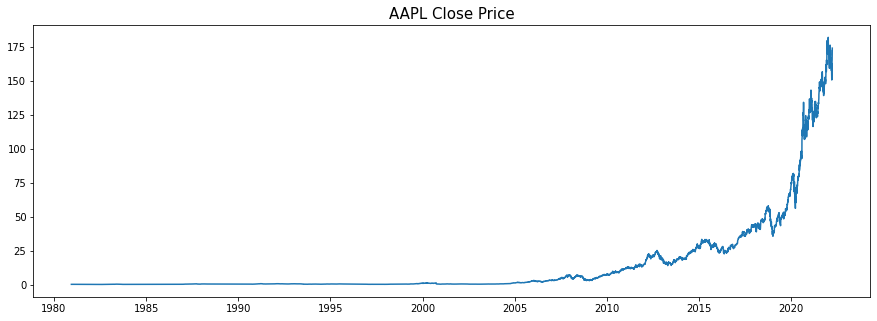

In [6]:
dates = data['Date'].values
close = data['Close'].values

plt.figure(figsize=(15,5))
plt.plot(dates, close)
plt.title('AAPL Close Price', fontsize=15)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaled_close = scaler.fit_transform(close.reshape(-1,1))

In [8]:
sc_close = scaled_close.reshape(-1)

In [9]:
from sklearn.model_selection import train_test_split

dates_train, dates_test, close_train, close_test = train_test_split(dates, sc_close, test_size=0.2, shuffle=False)

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
train_set = windowed_dataset(close_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(close_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, input_shape=[None,1], return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
  # tf.keras.layers.LSTM(60, input_shape=[None,1], return_sequences=True),
  # tf.keras.layers.LSTM(60),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [12]:
threshold_mae = (data['Close'].max() - data['Close'].min()) * 10/100
print(threshold_mae)

18.196088800000002


In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)#, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
history = model.fit(train_set, epochs=100, validation_data=test_set)

Epoch 1/100
83/83 [==============================] - 13s 51ms/step - loss: 1.5814e-04 - mae: 0.0082 - val_loss: 0.0551 - val_mae: 0.2453
Epoch 2/100
83/83 [==============================] - 2s 28ms/step - loss: 2.4658e-04 - mae: 0.0136 - val_loss: 0.0647 - val_mae: 0.2704
Epoch 3/100
83/83 [==============================] - 3s 28ms/step - loss: 1.2957e-04 - mae: 0.0112 - val_loss: 0.0489 - val_mae: 0.2277
Epoch 4/100
83/83 [==============================] - 3s 29ms/step - loss: 3.3646e-05 - mae: 0.0062 - val_loss: 0.0302 - val_mae: 0.1629
Epoch 5/100
83/83 [==============================] - 3s 29ms/step - loss: 2.0853e-05 - mae: 0.0048 - val_loss: 0.0274 - val_mae: 0.1553
Epoch 6/100
83/83 [==============================] - 2s 28ms/step - loss: 1.5612e-05 - mae: 0.0040 - val_loss: 0.0246 - val_mae: 0.1454
Epoch 7/100
83/83 [==============================] - 3s 29ms/step - loss: 1.2710e-05 - mae: 0.0036 - val_loss: 0.0231 - val_mae: 0.1415
Epoch 8/100
83/83 [============================

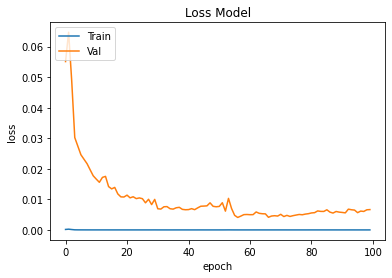

In [17]:
# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

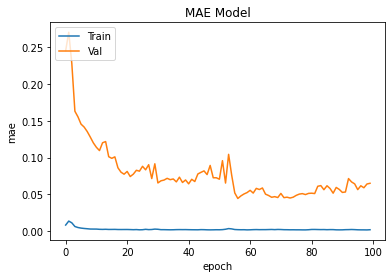

In [16]:
# Plot Mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()